In [1]:
!python3 -m numpy.f2py -c --quiet 'shape_functions (16).f90' -m shape_functions

WARN: Could not locate executable armflang


In [2]:
# Regular libraries
import math
import numpy as np
import copy
import time

# AI libraries 
import torch
from torch_geometric.data import Data
import torch.nn as nn

# FEM and SFC libraries
import shape_functions as sf
import space_filling_curves as sfc

# Mesh libraries
import pyvista
import toughio

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

# Load Mesh

In [3]:
filename = './Unstructured_Meshes/64x64_triangular_unstruc.vtk'
mesh = toughio.read_mesh(filename)

# FEM discretization using shape_functions module

In [4]:
# Define variables
nonods = mesh.n_points
u = np.array([[1]*nonods, [1]*nonods]).astype(float)
k = np.array([0.2] * nonods).astype(float)
sig = np.array([0] * nonods).astype(float)
s = np.array([0] * nonods).astype(float)
nloc = 3
ndim=2
dt = 0.1
totele = mesh.n_cells
# add 1 to each value because fortran indexes from 1
ndglno = mesh.cells[0][1].flatten() + 1

In [5]:
# Get the global node number for each node per FE 
x_all = [[], []]
for node in ndglno:
    x_all[0].append(mesh.points[node-1][1])
    x_all[1].append(mesh.points[node-1][0])

In [6]:
# create the adjacency matrix to store connections
adjacency_matrix = torch.eye(nonods)

# populate the connections with a one 
for element in mesh.cells[0][1]:
    for i in element:
        for j in element:
            if adjacency_matrix[i][j] != 1:
                adjacency_matrix[i][j] = 1

In [7]:
# Get the indices for the nonzeros(nnzs) in the adjacency matrix
a_indices = adjacency_matrix.nonzero().t().contiguous()

In [8]:
# Get the cola and fina lists for the sparse matrix
cola = adjacency_matrix.nonzero().t()[1] + 1
fina = np.zeros(nonods+1)
fina_value = 1
i=0

for occurrence in torch.bincount(adjacency_matrix.nonzero().t()[0]):
    fina[i] = fina_value
    fina_value += occurrence.item()
    i += 1
fina[-1] = fina_value
fina = fina.astype(int)

In [9]:
# Get the number of nnzs
ncola=cola.shape[0]

In [10]:
a, b, ml = sf.get_fe_matrix_eqn(x_all= x_all, u=u, k=k, sig=sig, s=s, fina=fina, cola=cola, ncola=ncola, ndglno=ndglno, nonods=nonods, totele=totele,nloc=nloc, ndim=ndim, ele_type=100)

 going into get_shape_funs_with_faces
 just about to allocate
 nloc, sngi, ngi, ndim, nface,max_face_list_no:           3           2           3           2           3           2
 npoly,ele_type:           1         100
 here 1
 here 2
 here 3
 going into get_shape_funs ***is a triangle or tet
 out of get_shape_funs
 going into SPECTR
 just leaving spectr
 out of SPECTR
 going into SPECTR
 just leaving spectr
 out of SPECTR


# Converting required variables to sparse

In [11]:
# ml is a diag matrix. so get the diag indices, eg (1,1), (2,2), (3,3) etc
indices_ml = torch.zeros((2,mesh.points.shape[0]))
for i in range(mesh.points.shape[0]):
    indices_ml[0][i] = i
    indices_ml[1][i] = i

indices_ml = indices_ml.int()

In [12]:
# convert ml matrix to sparse matrix
ml_sparse = torch.sparse_coo_tensor(indices_ml, ml, (nonods,nonods))

In [13]:
#convert ml inverse to sparse matrix
ml_inv_sparse = torch.sparse_coo_tensor(indices_ml, 1/ml, (nonods,nonods))

/tmp/ipykernel_1137/611407881.py:2: RuntimeWarning: divide by zero encountered in divide
  ml_inv_sparse = torch.sparse_coo_tensor(indices_ml, 1/ml, (nonods,nonods))


In [14]:
# convert a to sparse matrix  
a_sparse = torch.sparse_coo_tensor(a_indices, a, (nonods, nonods))

In [15]:
# convert b a tensor
b = torch.Tensor(b)

# Graph Neural Network

In [16]:
def set_boundary_conds(values): 
    '''Function to set the boundary nodes of the tensor 'values' to 0'''
    
    x_min = mesh.points.transpose()[0].min()
    x_max = mesh.points.transpose()[0].max()
    y_min = mesh.points.transpose()[1].min()
    y_max = mesh.points.transpose()[1].max()
    for i in range(nonods):
        if mesh.points.transpose()[0][i] == x_min or mesh.points.transpose()[0][i] == x_max or mesh.points.transpose()[1][i] == y_min or mesh.points.transpose()[1][i] == y_max:
            values[i][0] = 0

In [17]:
class GNN(nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
    
    def forward(self, values, ml=ml_sparse, ml_inv=ml_inv_sparse, a=a_sparse, dt=dt):
        '''Graph Neural Network to solve the scalar transport equation
        
        Inputs
        ---------------------------------------------------------------------------------
        values: Initial scalar field of the system in shape(nonods,1) as a torch tensor
        ml: Mass lumped matrix of the FEM discretization in shape(nonods, nonods) as a torch COO sparse tensor 
        ml_inv: Inverse of the mass lumped matrix in shape(nonods,nonods) as a torch COO sparse tensor
        a: FEM matrix that solves the equation: Ax=b, in shape(nonods,nonods) as a torch COO sparse tensor
        dt: Timestep in s
        
        '''
        
        # Get weights and time step
        values = torch.sparse.mm(torch.sparse.mm(- ml_inv, - ml + (dt * a)), values.view(nonods, 1))
        
        # set boundary conds.
        set_boundary_conds(values)
        
        return values   

# Initial Condition

In [18]:
values = torch.zeros(nonods)

In [19]:
# Set the values in some nodes in the y direction to 1
new_arrangement_y = np.argsort(mesh.points.transpose()[0])
for i in range(new_arrangement_y.shape[0]-4000, new_arrangement_y.shape[0]-3000):
    node = new_arrangement_y[i]
    values[node] = 1

In [20]:
# Change some of the values set to 1 to 0
new_arrangement_x = np.argsort(mesh.points.transpose()[1])
for i in range(new_arrangement_x.shape[0]-3500, new_arrangement_x.shape[0]):
    node = new_arrangement_x[i]
    values[node] = 0

for i in range(500):
    node = new_arrangement_x[i]
    values[node] = 0

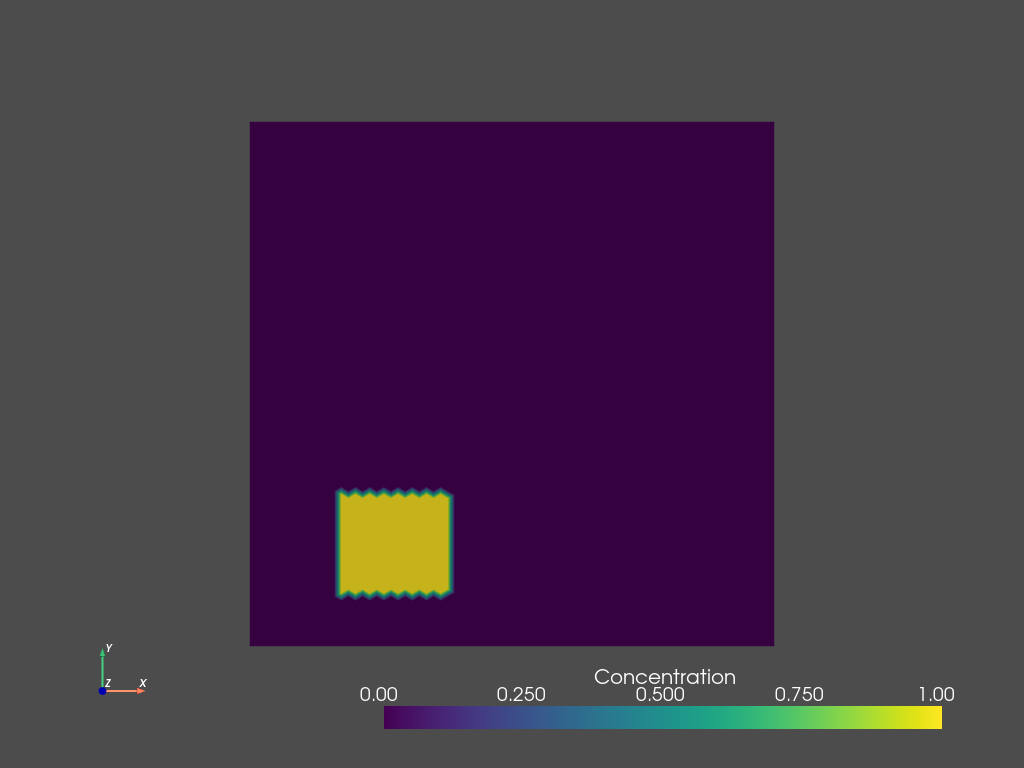

In [21]:
mesh.point_data = {'Concentration': values}
mesh.plot(notebook=True, cpos='xy', clim=[0,1], style='surface', jupyter_backend='static')

# Timestepping

In [22]:
values_py = values

In [23]:
# timestep
start = time.time()  

with torch.no_grad():
    for i in range(100):
        model = GNN()
        values_py = model(values=values_py)
        
end = time.time()
print('Computational time(s):',(end-start))

Computational time(s): 1.3099939823150635


# 100 timesteps

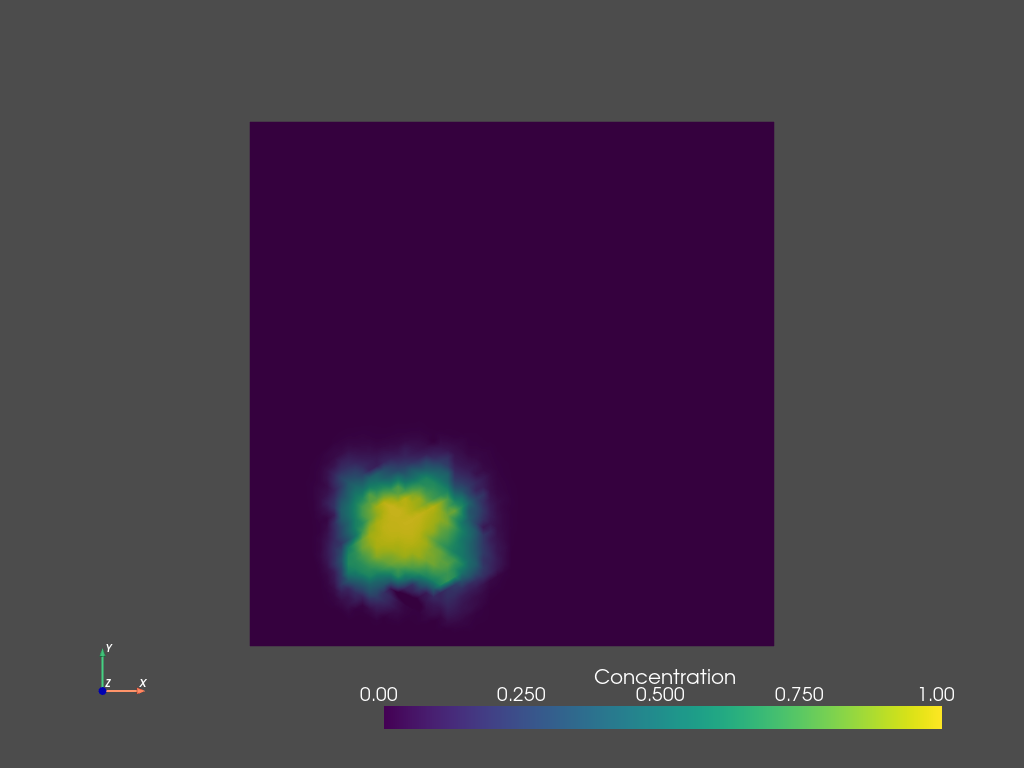

In [28]:
mesh.point_data = {'Concentration': values_py}
mesh.plot(notebook=True, cpos='xy', clim=[0,1], style='surface', jupyter_backend='static')

# 200 timesteps

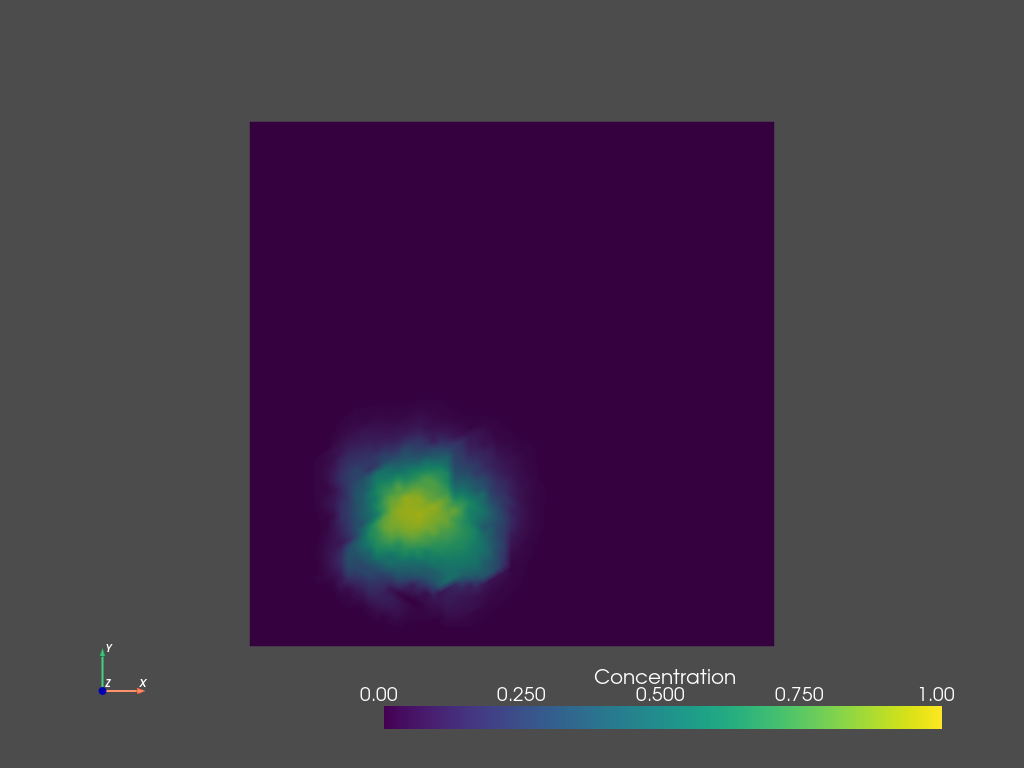

In [30]:
mesh.point_data = {'Concentration': values_py}
mesh.plot(notebook=True, cpos='xy', clim=[0,1], style='surface', jupyter_backend='static')

# 300 timesteps

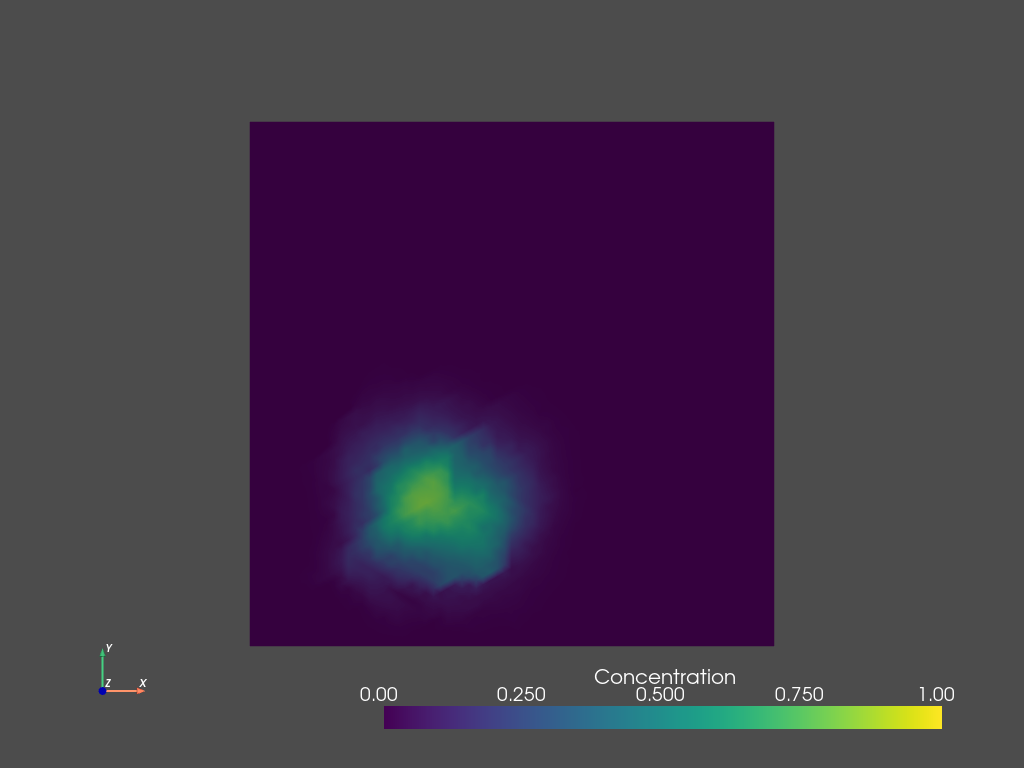

In [32]:
mesh.point_data = {'Concentration': values_py}
mesh.plot(notebook=True, cpos='xy', clim=[0,1], style='surface', jupyter_backend='static')

# 400 timesteps

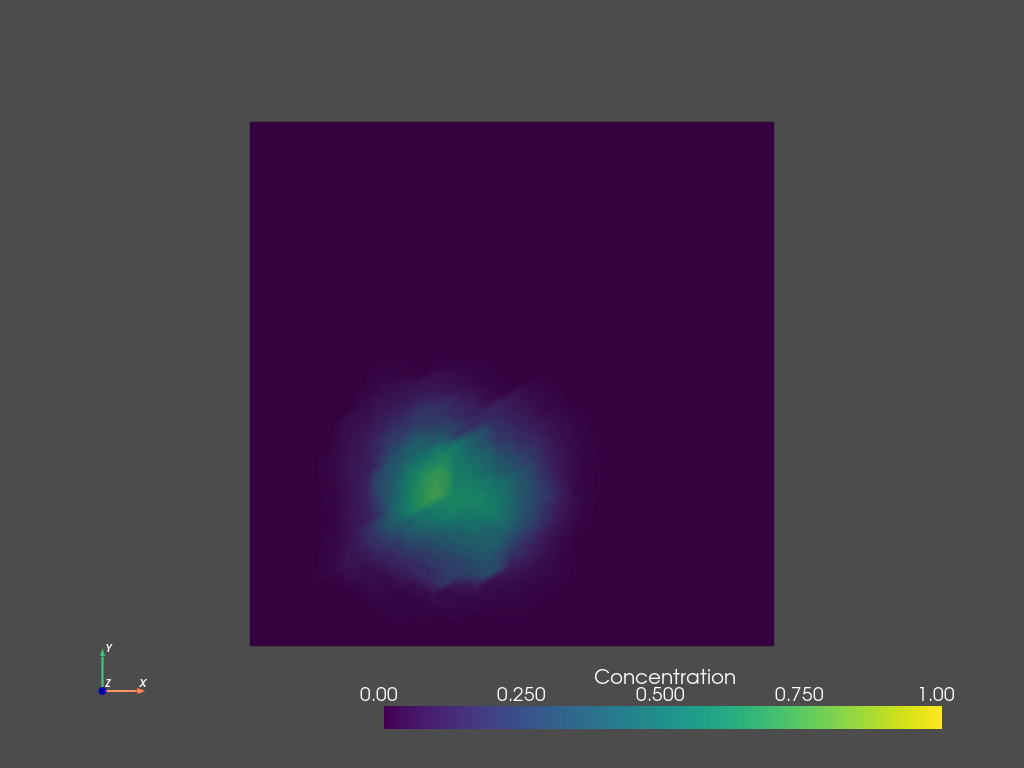

In [34]:
mesh.point_data = {'Concentration': values_py}
mesh.plot(notebook=True, cpos='xy', clim=[0,1], style='surface', jupyter_backend='static')

# 500 timesteps

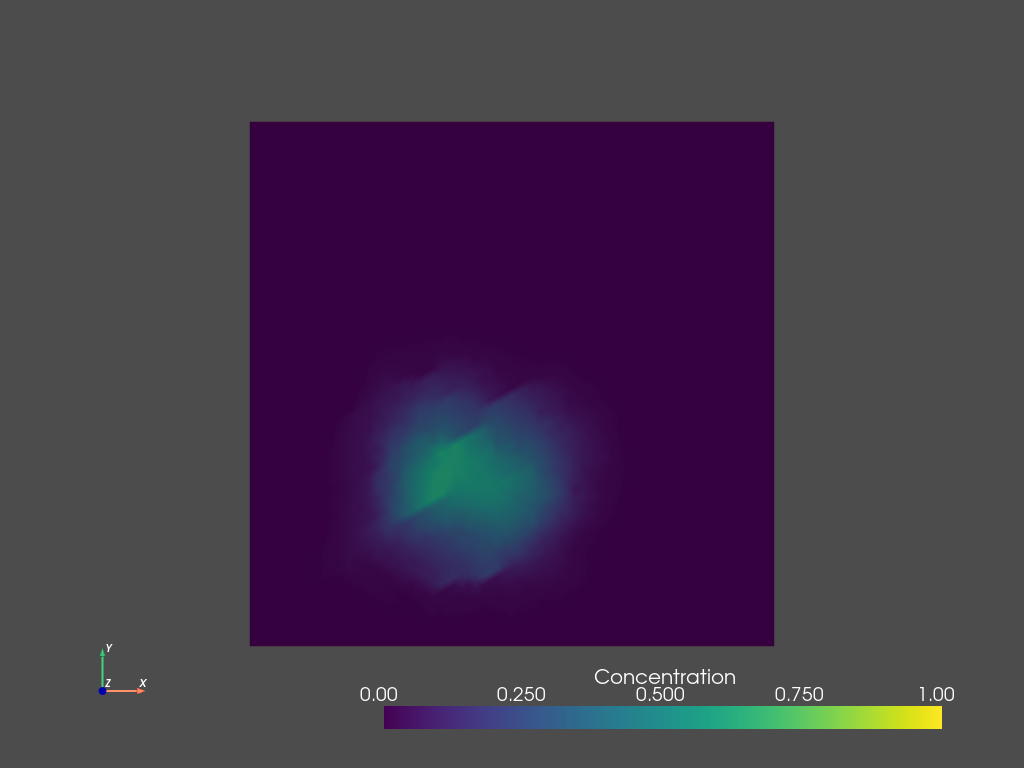

In [36]:
mesh.point_data = {'Concentration': values_py}
mesh.plot(notebook=True, cpos='xy', clim=[0,1], style='surface', jupyter_backend='static')

In [37]:
# mesh.point_data = {'conc': values_py}
# plotter = pyvista.Plotter(off_screen=True)
# plotter.add_mesh(mesh.to_pyvista(), clim=[0,1], style='surface',)
# plotter.camera_position='xy'
# plotter.show()